## ULMFiT Results and Analysis

Code to import the data:

In [1]:
# allow us to import data from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# make our root and base directories clear
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Fellowship-ai-challenge/'

import pandas as pd
df = pd.read_csv(base_dir + 'Tweets.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Code to preprocess Twitter data:

In [0]:
import re

def removeUnicode(text):
  """ Removes unicode strings like "\u002c" and "x96" """
  text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
  text = re.sub(r'[^\x00-\x7f]',r'',text)
  return text
  
def replaceURL(text):
  """Replaces url address with "url" """
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
  text = re.sub(r'#([^\s]+)', r'\1', text)
  return text

def replaceAtUser(text):
  """ Replaces "@user" with "atUser" """
  # text = re.sub('@[^\s]+','atUser',text)
  text = re.sub('@[^\s]+','',text)
  return text

def removeHashtagInFrontOfWord(text):
  """ Removes hastag in front of a word """
  text = re.sub(r'#([^\s]+)', r'\1', text)
  return text

def removeNumbers(text):
  """ Removes integers """
  text = ''.join([i for i in text if not i.isdigit()])         
  return text

def removeEmoticons(text):
  """ Removes emoticons from text """
  text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
  return text


""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
  patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
  for (pattern, repl) in patterns:
      (text, count) = re.subn(pattern, repl, text)
  return text

def preprocessTwitterData(df):
  """Function to apply text preprocessing functions to a dataframe"""
  
  # remove unicode
  df['text'] = df['text'].apply(removeUnicode)
  
  # replace url
  df['text'] = df['text'].apply(replaceURL)
  
  # replace '@' signs
  df['text'] = df['text'].apply(replaceAtUser)
  
  
  # replace hastags
  df['text'] = df['text'].apply(removeHashtagInFrontOfWord)
  
  # remove numbers in the tweets
  df['text'] = df['text'].apply(removeNumbers)
  
  # remove the emoticons
  df['text'] = df['text'].apply(removeEmoticons)
  
  # replace contractions
  df['text'] = df['text'].apply(replaceContraction)

## Functions to produce results fast

Now that we've described and explained the entire process, in order to get eventually get the best results, we need to test out various hyperparameters.

Let's define a function that can take in these hyperparameters as variables, and we can simply run the function once to do our entire analysis in one go.

It would be helpful to see a confusion matrix for each individual category so we can so let's define functions to plot the confusion matrix.

In [0]:
# import relevant libs
from fastai.text import *
from sklearn.model_selection import train_test_split

def ULMFiT_Airline_Sentiment(df,test_size=0.1, valid_size=0.1,preprocess=True,
                            lm_dropout=0.3,classifier_dropout=0.5,
                            max_lr_lm=1e-2,num_cycles_lm_ft=5,
                            bs_classifier=32,
                            lr_classifier_init=1e-2,
                             epochs_classifier_init=5,
                             lr_classifier_1=5e-3,
                             epochs_classifier_1=5,
                             lr_classifier_2=5e-3,
                             epochs_classifier_2=5,
                             lr_classifier_final=5e-3,
                             epochs_classifier_final=5
                            ):
  """
  Function to apply ULMFiT model to the Airline Sentiment
  
  @df: The dataframe with the data
  @test_size: how much data to set aside as test set
  @valid_size: how much data to set aside from training as validation set
  @preprocess: whether or not to preprocess the tweet data
  @lm_dropout: dropout to apply to the language model when fine-tuning
  @classifier_dropout: dropout to apply to the classifier when fine-tuning
  @max_lr_lm: the max learning rate for 1cycle pol. on LM
  @num_cycles_lm_ft: the number of epochs we use to train the LM after
  unfreezing.
  @bs_classifier: batch size for classifier
  @lr_classifier_init: learning rate for first training of classifier
  @epochs_classifier_init: number of epochs we use to train the classifier
  before gradual unfreezing
  @lr_classifier_1:learning rate for training of classifier after 1st unfreeze
  @epochs_classifier_1:number of epochs "                              "
  @lr_classifier_2:learning rate for training of classifier after 2nd unfreeze
  @epochs_classifier_2: number of epochs "                             "
  @lr_classifier_final: learning rate after entire model unfrozen
  @epochs_classifier_final:epochs "                         "
  """
  # preprocessing data
  if preprocess:
    print("preprocessing Twitter data")
    preprocessTwitterData(df)
  
  # only need text and airline_sentiment
  df = df[['text','airline_sentiment']]
  
  # split the data into train and test
  df_train, df_test = train_test_split(df,test_size=test_size,random_state=40)
  
  # Convert the cleaned training and testing data
  # into their own CSV files which we can import
  # later to perform modeling on them

  # these lines write CSV files to our current directory
  df_train.to_csv('twitter_data_cleaned_train.csv')
  df_test.to_csv('twitter_data_cleaned_test.csv')
  
  print("Getting LM data into appropriate form")
  # TextMLDataBunch process
  data_lm = TextLMDataBunch.from_csv(path='',
                                     csv_name='twitter_data_cleaned_train.csv',
                                     valid_pct=valid_size)
  
  
  # LM learner
  learn = language_model_learner(data_lm,AWD_LSTM,drop_mult=lm_dropout)
  
  print("Fine-tuning language model")
  # one cycle training, always use moms=(0.85,0.75), always use one epoch on
  # this step to avoid overly fine-tuning
  learn.fit_one_cycle(1,max_lr=max_lr_lm)
  
  # unfreeze LM and do discriminative fine-tuning
  learn.fit_one_cycle(cyc_len=num_cycles_lm_ft, 
                      max_lr=slice(max_lr_lm/(2.6**4),max_lr_lm))
  
  # save the encoding layer
  learn.save_encoder('encoder')
  
  print("LM fine-tuning complete")
  # Start Classifier fine-tuning
  
  print("Getting Classifier data into appropriate form")
  data_class = TextClasDataBunch.from_csv(path='',
                                          csv_name='twitter_data_cleaned_train.csv',
                              vocab=data_lm.train_ds.vocab,
                                          bs=bs_classifier
                                          ,text_cols='text'
                                          ,label_cols='airline_sentiment')
  
  # Classifier Learner
  learn = text_classifier_learner(data_class,AWD_LSTM,
                                  drop_mult=classifier_dropout)
  
  # Load the pretrained encoder into the model
  learn.load_encoder('encoder')
  
  print("Started Classifier fine-tuning")
  # Training before gradual unfreezing
  learn.fit_one_cycle(epochs_classifier_init,lr_classifier_init)
  
  print("Started gradual unfreezing")
  # Start gradual unfreezing process
  
  # unfreeze next layer and train (discriminative layer training)
  learn.freeze_to(-2)
  learn.fit_one_cycle(epochs_classifier_1,
                      slice(lr_classifier_1/(2.6**4),lr_classifier_1))
  
  # unfreeze next layer and train (discriminative layer training)
  learn.freeze_to(-3)
  learn.fit_one_cycle(epochs_classifier_2,
                      slice(lr_classifier_2/(2.6**4),lr_classifier_2))
  
  # unfreeze everything and train
  learn.fit_one_cycle(epochs_classifier_final,
                      slice(lr_classifier_final/(2.6**4),lr_classifier_final))
  
  print("ULMFiT done!")
  # return the model
  return learn




import matplotlib.pyplot as plt
# Taken from the scikit-learn documentation
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Started Classifier fine-tuning


epoch,train_loss,valid_loss,accuracy,time
0,0.684226,0.584143,0.758346,00:07
1,0.700332,0.555559,0.767071,00:07
2,0.646435,0.533771,0.786798,00:07
3,0.639386,0.541082,0.773520,00:07
4,0.625220,0.530479,0.777693,00:07


Started gradual unfreezing


epoch,train_loss,valid_loss,accuracy,time
0,0.615485,0.511355,0.798938,00:08
1,0.617296,0.519167,0.790592,00:08
2,0.571508,0.485129,0.809560,00:08
3,0.510683,0.474465,0.810698,00:08
4,0.475067,0.474577,0.810319,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.475503,0.465757,0.812216,00:14
1,0.541642,0.471177,0.820561,00:13
2,0.423801,0.471732,0.819803,00:14
3,0.321694,0.500005,0.821320,00:13
4,0.252500,0.505723,0.824355,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.282763,0.513888,0.815250,00:14
1,0.349025,0.564520,0.816009,00:14
2,0.280702,0.532669,0.816009,00:14
3,0.199209,0.589608,0.810698,00:14
4,0.132459,0.595762,0.821700,00:14


ULMFiT done!
Accuracy: 0.828551912568306


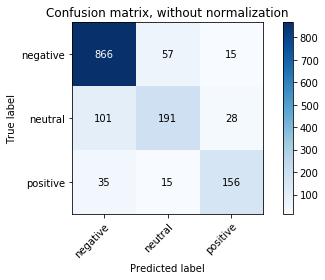

In [4]:
# example of using the function with accuracy and confusion matrix

# import metrics from sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# apply function to get learner
learn = ULMFiT_Airline_Sentiment(df,preprocess=False)

# put test data in test df
df_test = pd.read_csv('twitter_data_cleaned_test.csv')

# add a column with the predictions on the test set
df_test['sentiment_pred'] = df_test['text'].apply(lambda row:str(learn.predict(row)[0]))


# print the accuracy against the test set
print("Accuracy: {}".format(accuracy_score(df_test['airline_sentiment'],df_test[
    'sentiment_pred'
])))

# plot the confusion matrix for the test set
plot_confusion_matrix(df_test['airline_sentiment'],df_test['sentiment_pred'],
                      classes=['negative','neutral','positive'])
plt.show()

# Analysis of results

### Why accuracy as a metric?

We could use other classification metrics (such as recall, precision, etc.) but we're mostly interested in seeing how our results compare to other models. Both online and in research papers, these models' effectiveness are typically measured with accuracy.

### Results from other baseline models

We're trying to gauge the effectiveness of ULMFiT, so it's important to measure our results against other common baselines models. 

From Kaggle (all are accuracies on testing sets):
- Random Forest: 81.3%
- AdaBoost:78.6%
- Keras deep learning: 77.9%
- Linear SVM: 78.5%



### Our results

As shown above, our accuracy on the testing set was **82.9%**. This is a slight improvement from the top score (amongst baseline ML models). The process of tuning the hyperparameters was done through trial and error/rerunning the Google Colab notebook. 

Most of the hyperparameter tunings (such as individual learning rates for the gradual unfreezes) resulted in negligible changes in accuracy. Increasing the epochs for different training rounds usually resulted in overfitting, which confirms Jeremy Howard's point about overly aggressive fine-tuning. 

Surprisingly, however, **preprocessing the Twitter data resulted in noticeably worse results (about 1-2% changes in accuracy).** This could be because of poor preprocessing techniques. It could also be because of our preprocessing techniques clashing with those of the fastai library.

From the confusion matrix, we can see that there were quite a few samples that we predicted negative, when they were actually neutral. Thus, the model is slightly biased towards predicting a negative sentiment: this might have to do with the fact that there are so many negative Tweets in the first place.

Overall, our results were better than those of most baseline models. This is likely due to the relevant features learned by the pretrained language model. Furthermore, our fine-tuning process was simple and computationally efficient.

## Possible improvements/weaknesses of the model

- We didn't exhaust all of our possible ways of preprocessing the Twitter data. In fact, taking preprocessing out gave us better results. Perhaps we could investigate more about preprocessing data in order to improve the results.
- We used the implementation inside the fastai library for our pretrained language model. As a result, we couldn't make that many tweaks to it (such as taking out a particular dropout) that might improve performance for this particular dataset. In the future, we may benefit from implementing part of the model from scratch.
- If we acquire a better language model, we might be able to improve our results. Perhaps we could integrate a model such as BERT (Google) or GPT-2 to do transfer learning with ULMFiT.
- We didn't have an efficient way of exploring different hyperparameters aside from doing trial and error. In the future, we could use a customized function and advanced computational resources to explore a greater set of hyperparameters.

Ultimately, the best two directions for improving our results, as well as text classification results in general are:
- **Finding more sophisticated ways to create language models that beat the state-of-the art.**
- **Researching more about transfer learning in general, so we can improve our understanding of ULMFiT and craft better ways of fine-tuning the model.**

